In [1]:
# Test how much volume of the models is filled up by the data (comparing gaussian to MIND)

In [2]:
%load_ext autoreload
%autoreload 2

# Inclusions
import socket
import sys, os
if socket.gethostname()=='Andrews-MacBook-Pro.local':
    sys.path.append("/Users/landauland/Documents/GitHub/RatInABox")#os.path.join('C:/', 'Users','andrew','Documents','GitHub','RatInABox'))
else:
    sys.path.append(os.path.join('C:/', 'Users','andrew','Documents','gitRepositories','RatInABox'))

import time
import numpy as np
import numba as nb
import scipy
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import simulateHippocampalData as simData 
import mind_mindModel1 as mind
import mind_ppca1 as mppca

from tqdm.notebook import tqdm, trange

In [3]:
# Generate and plot some place cells and grid cells
NP = 50 # number of place cells
NG = 50 # number of grid cells
boxLength = 88 # 88cm box length (square arena)
gNoiseAmp = 1/100000 # noise standard deviation relative to signal standard deviation
placeWidth = 41.6 # place field with in cm (full-width at half-maximum of an isotropic gaussian function)
numGridModules = 4 # number of grid modules (in increasing scale)
gridExpansion = 1.3 # relative scale increase of each consecutive grid module
baseGridSpacing = 39.8 # cm
baseGridWidth = 27.4 # cm (full-width at half-maximum of an isotropic gaussian function)

In [4]:
xpos,ypos = simData.getBoxCoord(boxLength) 

# Create Library of Place Cells
xcPlace,ycPlace = zip(*[simData.randCentroid(boxLength) for _ in range(NP)]) # centroid
placeLibrary = np.array([simData.getPlaceMap(xcPlace[n],ycPlace[n],xpos,ypos,placeWidth) for n in range(NP)])

# Create Library of Grid Cells
xcGrid,ycGrid = zip(*[simData.randCentroid(boxLength) for _ in range(NG)]) # centroid
spGrid = tuple(baseGridSpacing * (gridExpansion**np.random.randint(0,numGridModules)) for _ in range(NG)) # grid spacing
agGrid = tuple(np.pi/3*np.random.random() for _ in range(NG)) # angle of lattice
gridLibrary = np.array([simData.getGridMap(xcGrid[n],ycGrid[n],xpos,ypos,spGrid[n],agGrid[n]) for n in range(NG)])

# Sanity Check!!
print(f'Shape of place library is {np.shape(placeLibrary)}')
print(f'Shape of grid library is {np.shape(gridLibrary)}')
print(f"Min/max of place library is {np.min(placeLibrary):.1f}/{np.max(placeLibrary)}")
print(f"Min/max of grid library is {np.min(gridLibrary):.1f}/{np.max(gridLibrary)}")

Shape of place library is (50, 88, 88)
Shape of grid library is (50, 88, 88)
Min/max of place library is 0.0/1.0
Min/max of grid library is -0.5/1.0


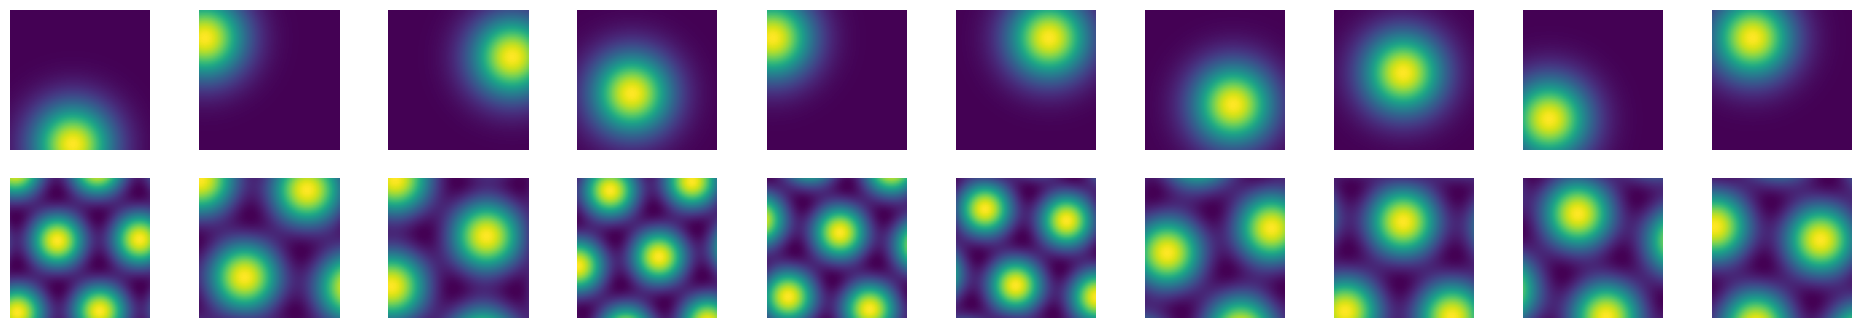

In [5]:
# Show Examples
numExamplesEach = 10
f, ax = plt.subplots(2,numExamplesEach,figsize=(24,4))
for n in range(numExamplesEach):
    ax[0,n].imshow(placeLibrary[np.random.randint(NP)])
    ax[1,n].imshow(gridLibrary[np.random.randint(NG)])
    ax[0,n].axis('off')
    ax[1,n].axis('off')

In [9]:
# Generate a trajectory in the environment
Env = simData.Environment({"scale":boxLength/100}) # (RatInABox uses meters)
Ag = simData.Agent(Env,{"dt":0.1,"speed_mean":0.08})
for i in range(100000): # Use standard number of datapoints, independent of time step
    Ag.update();

# Get trajectory variables
t, pos = np.array(Ag.history["t"]), np.array(Ag.history["pos"])
pos = pos * 100 # convert back to centimeters (to use as index)
posidx = np.floor(pos).astype('int8')

In [10]:
# Return place and grid cell activity along trajectory, with noise if requested
placeActivitySignal = placeLibrary[:,posidx[:,0],posidx[:,1]].T
gridActivitySignal = gridLibrary[:,posidx[:,0],posidx[:,1]].T
hippoActivitySignal = np.concatenate((placeActivitySignal,gridActivitySignal),axis=1)

# Add Noise
gNoiseAmp = 1/5
gNoisePlace = gNoiseAmp * np.std(placeActivitySignal,axis=0)
gNoiseHippo = gNoiseAmp * np.std(hippoActivitySignal,axis=0)
placeActivity = placeActivitySignal + np.random.normal(0,gNoisePlace,placeActivitySignal.shape)
hippoActivity = hippoActivitySignal + np.random.normal(0,gNoiseHippo,hippoActivitySignal.shape)

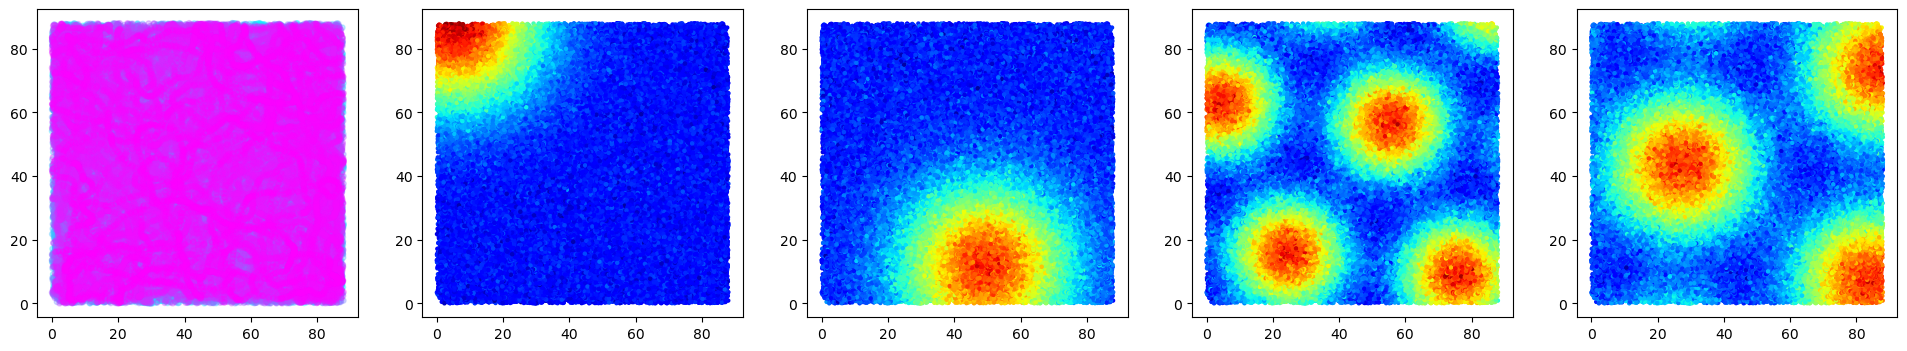

In [11]:
# Plot Trajectory and plot examples of place cell and grid cell activity overlaid on trajectory
numExamplesEach = 2
pexidx = np.random.randint(0,NP,numExamplesEach)
gexidx = np.random.randint(0,NG,numExamplesEach)
f, ax = plt.subplots(1,numExamplesEach*2+1,figsize=(24,4))
# Ag.plot_trajectory(ax=ax[0])
plt.set_cmap('cool')
ax[0].scatter(pos[:,0],pos[:,1],s=15,c=range(pos.shape[0]),alpha=0.3)
plt.set_cmap('jet')
for n in range(numExamplesEach):
    ax[n+1].scatter(pos[:,0],pos[:,1],s=5,c=placeActivity[:,pexidx[n]])
    ax[n+1+numExamplesEach].scatter(pos[:,0],pos[:,1],s=5,c=hippoActivity[:,NP+gexidx[n]])

In [12]:
opts = {'numScafPoints':800,'nLeaf':100}
numTrees = 20

placeMind = mind.mindModel(opts)
placeMind.addData(placeActivity)
placeMind.constructForest(numTrees,simpleUpdates=True)
placeMind.summarizeForest()
placeMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.
Fitting PPCA Tree 1/20, eta: nan seconds...
Fitting PPCA Tree 2/20, eta: 31.2 seconds...
Fitting PPCA Tree 3/20, eta: 40.9 seconds...
Fitting PPCA Tree 4/20, eta: 46.4 seconds...
Fitting PPCA Tree 5/20, eta: 49.5 seconds...
Fitting PPCA Tree 6/20, eta: 51.6 seconds...
Fitting PPCA Tree 7/20, eta: 53.5 seconds...
Fitting PPCA Tree 8/20, eta: 54.6 seconds...
Fitting PPCA Tree 9/20, eta: 55.6 seconds...
Fitting PPCA Tree 10/20, eta: 56.2 seconds...
Fitting PPCA Tree 11/20, eta: 56.6 seconds...
Fitting PPCA Tree 12/20, eta: 57.1 seconds...
Fitting PPCA Tree 13/20, eta: 57.5 seconds...
Fitting PPCA Tree 14/20, eta: 57.7 seconds...
Fitting PPCA Tree 15/20, eta: 58.1 seconds...
Fitting PPCA Tree 16/20, eta: 58.4 seconds...
Fitting PPCA Tree 17/20, eta: 58.7 seconds...
Fitting PPCA Tree 18/20, eta: 59.0 seconds...
Fitting PPCA Tree 19/20, eta: 59.2 seconds...
Fitting PPCA Tree 20/20, eta: 59.4 seconds...


  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
opts = {'numScafPoints':800,'nLeaf':100}
numTrees = 20

hippoMind = mind.mindModel(opts)
hippoMind.addData(hippoActivity)
hippoMind.constructForest(numTrees,simpleUpdates=True)
hippoMind.summarizeForest()
hippoMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.
Fitting PPCA Tree 1/20, eta: nan seconds...
Fitting PPCA Tree 2/20, eta: 53.6 seconds...
Fitting PPCA Tree 3/20, eta: 71.5 seconds...
Fitting PPCA Tree 4/20, eta: 81.1 seconds...
Fitting PPCA Tree 5/20, eta: 86.4 seconds...
Fitting PPCA Tree 6/20, eta: 89.9 seconds...
Fitting PPCA Tree 7/20, eta: 92.8 seconds...
Fitting PPCA Tree 8/20, eta: 95.1 seconds...
Fitting PPCA Tree 9/20, eta: 97.4 seconds...
Fitting PPCA Tree 10/20, eta: 99.1 seconds...
Fitting PPCA Tree 11/20, eta: 100.3 seconds...
Fitting PPCA Tree 12/20, eta: 101.5 seconds...
Fitting PPCA Tree 13/20, eta: 102.8 seconds...
Fitting PPCA Tree 14/20, eta: 103.6 seconds...
Fitting PPCA Tree 15/20, eta: 104.5 seconds...
Fitting PPCA Tree 16/20, eta: 105.4 seconds...
Fitting PPCA Tree 17/20, eta: 106.2 seconds...
Fitting PPCA Tree 18/20, eta: 106.8 seconds...
Fitting PPCA Tree 19/20, eta: 107.3 seconds...
Fitting PPCA Tree 20/20, eta: 107.9 seconds...


  0%|          | 0/20 [00:00<?, ?it/s]

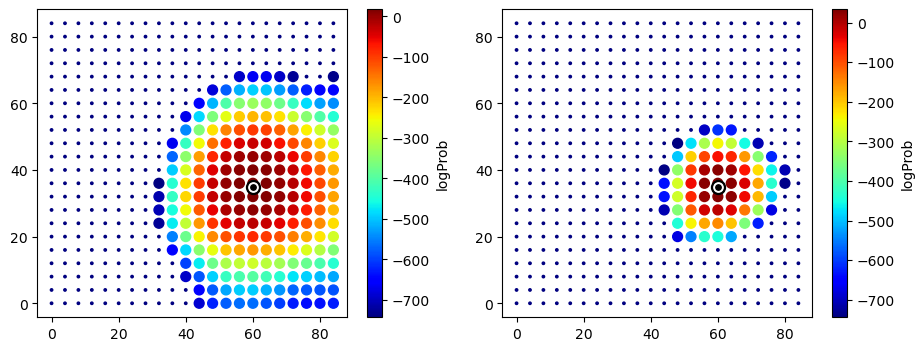

In [14]:
# Compute probability of transitions from one point to all other possible points
xp4,yp4 = simData.getBoxCoord(boxLength,4)
xpv = xp4.reshape(-1)
ypv = yp4.reshape(-1)
placeMesh = (placeLibrary[:,xpv,ypv].T - placeMind.drPPCA.u) @ placeMind.drPPCA.v
hippoMesh = (np.concatenate((placeLibrary[:,xpv,ypv].T,gridLibrary[:,xpv,ypv].T),axis=1) - hippoMind.drPPCA.u) @ hippoMind.drPPCA.v

xC,yC = 60,35
placeCenter = (placeLibrary[:,xC,yC].T - placeMind.drPPCA.u) @ placeMind.drPPCA.v
hippoCenter = (np.concatenate((placeLibrary[:,xC,yC].reshape(1,-1),gridLibrary[:,xC,yC].reshape(1,-1)),axis=1) - hippoMind.drPPCA.u) @ hippoMind.drPPCA.v

placeMeshProb = placeMind.smartForestLikelihood(np.repeat(placeCenter.reshape(1,-1),placeMesh.shape[0],axis=0), placeMesh)
hippoMeshProb = hippoMind.smartForestLikelihood(np.repeat(hippoCenter.reshape(1,-1),hippoMesh.shape[0],axis=0), hippoMesh)

fig,ax = plt.subplots(1,2,figsize=(11,4))

placeNonzero = np.where(placeMeshProb != 0)[0]
placeZero = np.where(placeMeshProb == 0)[0]
cLimits = (np.min(np.log(placeMeshProb[placeNonzero])), np.max(np.log(placeMeshProb[placeNonzero])))
xx = ax[0].scatter(xpv[placeNonzero],ypv[placeNonzero],s=50,c=np.log(placeMeshProb[placeNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xpv[placeZero],ypv[placeZero],s=3,c=cLimits[0]*np.ones_like(xpv[placeZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xC,yC,s=100,c='k')
ax[0].scatter(xC,yC,s=45,c='w')
ax[0].scatter(xC,yC,s=15,c='k')
plt.colorbar(xx,ax=ax[0],label='logProb')

hippoNonzero = np.where(hippoMeshProb != 0)[0]
hippoZero = np.where(hippoMeshProb == 0)[0]
cLimits = (np.min(np.log(hippoMeshProb[hippoNonzero])), np.max(np.log(hippoMeshProb[hippoNonzero])))
xx = ax[1].scatter(xpv[hippoNonzero],ypv[hippoNonzero],s=50,c=np.log(hippoMeshProb[hippoNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xpv[hippoZero],ypv[hippoZero],s=3,c=cLimits[0]*np.ones_like(xpv[hippoZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xC,yC,s=100,c='k')
ax[1].scatter(xC,yC,s=45,c='w')
ax[1].scatter(xC,yC,s=15,c='k')
plt.colorbar(xx,ax=ax[1],label='logProb')

In [87]:
# Now - test how much the data "fills up" the probability distribution -- according to the gaussian and the MIND model 

# Helper function
def getProbabilityPPCA(data, drPPCA):
    udata = data - drPPCA.u
    N = len(drPPCA.u)
    nonData = (2*np.pi)**(-N/2) * np.linalg.det(drPPCA.cv)**(-1/2)
    expArgument = -1/2 * np.sum(udata @ drPPCA.icv * udata, axis=1)
    return nonData * np.exp(expArgument)

# Get dimensionality reduced data
drPlace = placeMind.drPPCA.processData(placeActivity)
drHippo = hippoMind.drPPCA.processData(hippoActivity)

# Measure probability of data according to the ppca models
pdPlacePPCA = getProbabilityPPCA(placeActivity, placeMind.drPPCA)
pdHippoPPCA = getProbabilityPPCA(hippoActivity, hippoMind.drPPCA)

# Measure probability of data according to the MIND models
pdPlaceMIND = placeMind.smartForestLikelihood(drPlace, drPlace)
pdHippoMIND = hippoMind.smartForestLikelihood(drHippo, drHippo) 

(array([2.0000e+00, 9.0000e+00, 8.5000e+01, 4.2900e+02, 2.4620e+03,
        9.4560e+03, 2.5987e+04, 3.9097e+04, 2.0830e+04, 1.6430e+03]),
 array([-4.08427806, -0.40056831,  3.28314145,  6.9668512 , 10.65056096,
        14.33427071, 18.01798047, 21.70169022, 25.38539998, 29.06910974,
        32.75281949]),
 <BarContainer object of 10 artists>)

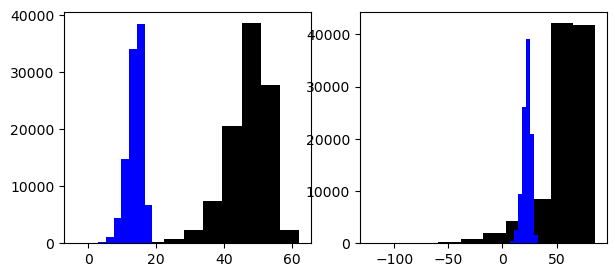

In [93]:
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].hist(np.log(pdPlacePPCA), label='PPCA', color='k')
ax[0].hist(np.log(pdPlaceMIND), label='MIND', color='b')

ax[1].hist(np.log(pdHippoPPCA), label='PPCA', color='k')
ax[1].hist(np.log(pdHippoMIND), label='MIND', color='b')

In [80]:
placeMind.drPPCA.v.shape

(50, 10)

In [24]:
placeActivity.shape

(100000, 50)

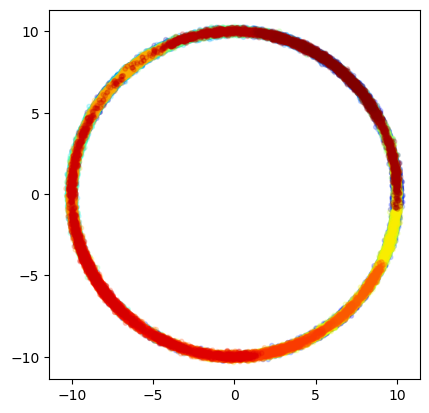

In [107]:
# Test if I can do this correctly with random walk on a circle + noise
radius = 10
noise = 0.1
ND = 100000
rwSpeed = 0.02
rwStep = np.random.normal(0,rwSpeed,ND)
rwAngle = np.cumsum(rwStep)

xData = radius * np.cos(rwAngle) + np.random.normal(0,noise,ND)
yData = radius * np.sin(rwAngle) + np.random.normal(0,noise,ND)
cData = np.stack((xData,yData),axis=1)

plt.scatter(cData[:,0], cData[:,1], s=10, c=range(ND), alpha=0.2)
plt.gca().set_aspect('equal')

In [108]:
# Create silly little MIND model
opts = {'numScafPoints':800,'nLeaf':50}
numTrees = 10

circleMind = mind.mindModel(opts)
circleMind.addData(cData)
circleMind.constructForest(numTrees,simpleUpdates=True)
circleMind.summarizeForest()
circleMind.constructScaffold()

Adding data: constructing PPCA model of full dataset.
Fitting PPCA Tree 1/10, eta: nan seconds...
Fitting PPCA Tree 2/10, eta: 11.2 seconds...
Fitting PPCA Tree 3/10, eta: 15.0 seconds...
Fitting PPCA Tree 4/10, eta: 16.8 seconds...
Fitting PPCA Tree 5/10, eta: 17.9 seconds...
Fitting PPCA Tree 6/10, eta: 18.6 seconds...
Fitting PPCA Tree 7/10, eta: 19.1 seconds...
Fitting PPCA Tree 8/10, eta: 19.4 seconds...
Fitting PPCA Tree 9/10, eta: 19.7 seconds...
Fitting PPCA Tree 10/10, eta: 19.9 seconds...


  0%|          | 0/10 [00:00<?, ?it/s]

In [109]:
# Measure Probability of each point transitioning to itself (which is a way of measuring probability of each point)
# ---- because it finds the best scaffold point, then estimates the probability according to that scaffold point... ----
probMind = circleMind.smartForestLikelihood(cData, cData)

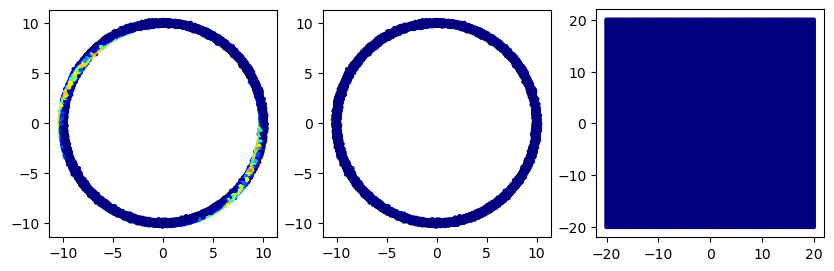

In [112]:
# Measure probability of each point with PPCA
nGrid = 100
xgrid,ygrid = np.meshgrid(np.linspace(-2*radius,2*radius,nGrid),np.linspace(-2*radius,2*radius,nGrid))
gridData = np.stack((np.reshape(xgrid,-1),np.reshape(ygrid,-1)),axis=1)
dFromCenter = np.sqrt(xgrid**2 + ygrid**2)

def getProbabilityPPCA(data, drPPCA):
    udata = data - drPPCA.u
    N = len(drPPCA.u)
    nonData = (2*np.pi)**(-N/2) * np.linalg.det(drPPCA.cv)**(-1/2)
    expArgument = -1/2 * np.sum(udata @ drPPCA.icv * udata, axis=1)
    return nonData * np.exp(expArgument), nonData

probData,maxPPCA = getProbabilityPPCA(cData, circleMind.drPPCA)
probGrid = getProbabilityPPCA(gridData, circleMind.drPPCA)[0]
maxColor = np.max((maxPPCA, np.max(probMind)))

fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].scatter(cData[:,0],cData[:,1],s=5,c=probMind, vmin=0, vmax=maxColor)
ax[0].set_aspect('equal')

ax[1].scatter(cData[:,0],cData[:,1],s=5,c=probData, vmin=0, vmax=maxColor)
ax[1].set_aspect('equal')

ax[2].scatter(gridData[:,0],gridData[:,1],s=5,c=probGrid, vmin=0, vmax=maxColor)
ax[2].set_aspect('equal')

(array([6.0000e+00, 2.5000e+01, 1.2400e+02, 5.1500e+02, 1.9120e+03,
        5.9320e+03, 1.2121e+04, 1.7192e+04, 2.0294e+04, 4.1879e+04]),
 array([-67.35944183, -60.40443618, -53.44943054, -46.49442489,
        -39.53941924, -32.58441359, -25.62940795, -18.6744023 ,
        -11.71939665,  -4.76439101,   2.19061464]),
 <BarContainer object of 10 artists>)

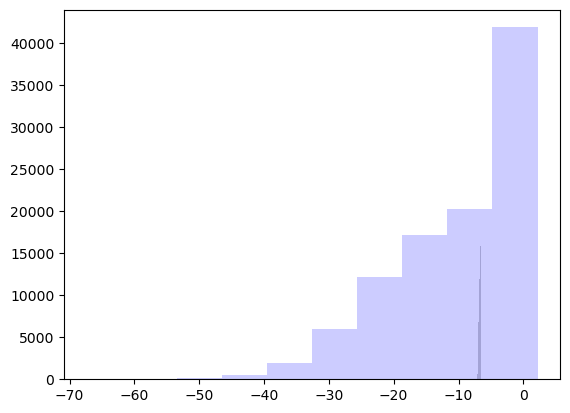

In [114]:
plt.hist(np.log(probData),label='PPCA',color='k',alpha=0.2)
plt.hist(np.log(probMind),label='MIND',color='b',alpha=0.2)